# Project : AT&T Spam Detector 2/2
## Using a pretrained embedding model *(transfer learning)*

In [1]:
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as hub

# model building
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

# split data into train and test set
from sklearn.model_selection import train_test_split

# plot lib
import matplotlib.pyplot as plt

# score handling
from sklearn.metrics import confusion_matrix, accuracy_score

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('src/spam.csv', encoding = "ISO-8859-1")

In [3]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
# With 0.99 percent of missing values, I will remove these 3 columns :
df.drop(columns=["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], inplace=True)

# I will rename main columns with relevant names 
# I will replace the labels by 0(ham) and 1(spam)
df = df.rename(columns={"v1":"label", "v2":"sms_content"})
df['label'] = df['label'].map( {'spam': 1, 'ham': 0} )
df.head()

,label,sms_content
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
X = df['sms_content']
y = df['label']

In [6]:
# Train Test Split
xtrain, xval, ytrain, yval = train_test_split(X,y, test_size=0.15)

In [7]:
# Batch
train = tf.data.Dataset.from_tensor_slices((xtrain, ytrain))
val = tf.data.Dataset.from_tensor_slices((xval, yval))

In [23]:
train_examples_batch, train_labels_batch = next(iter(train.batch(5)))
train_examples_batch

<tf.Tensor: shape=(5,), dtype=string, numpy=
array([b'Thanks for your Ringtone Order, Reference T91. You will be charged GBP 4 per week. You can unsubscribe at anytime by calling customer services on 09057039994',
       b'A Boy loved a gal. He propsd bt she didnt mind. He gv lv lttrs, Bt her frnds threw thm. Again d boy decided 2 aproach d gal , dt time a truck was speeding towards d gal. Wn it was about 2 hit d girl,d boy ran like hell n saved her. She asked \'hw cn u run so fast?\' D boy replied \\Boost is d secret of my energy\\" n instantly d girl shouted \\"our energy\\" n Thy lived happily 2gthr drinking boost evrydy Moral of d story:- I hv free msgs:D;): gud ni8"',
       b"I'm tired of arguing with you about this week after week. Do what you want and from now on, i'll do the same.",
       b'Please call our customer service representative on FREEPHONE 0808 145 4742 between 9am-11pm as you have WON a guaranteed \xc3\xa5\xc2\xa31000 cash or \xc3\xa5\xc2\xa35000 prize!',
       b

In [24]:
train_labels_batch

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([1, 0, 0, 1, 1], dtype=int64)>

### I will use the **pretrained embedding model** : google/nnlm-en-dim50/2 :
- *source Tensorflow Hub     : https://tfhub.dev/google/nnlm-en-dim50/2*
- *Text embedding with pre-built OOV. Maps from text to 50-dimensional embedding vectors*
- *The module preprocesses its input by splitting on spaces*
- *Small fraction of the least frequent tokens and embeddings (~2.5%) are replaced by hash buckets*
- *Word embeddings are combined into sentence embedding using the **sqrtn** combiner*

##### Additional informations :
- *source Tensorflow tutorials : https://www.tensorflow.org/tutorials/keras/text_classification_with_hub*
- *Benefit from **transfer learning***
- *Text preprocessing not necessary*

In [10]:
# Downloading pre trained model

embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"                      # --> Run well 
#embedding = "https://tfhub.dev/google/nnlm-en-dim128/2"                    Time computing is a little bit long and overfit
#embedding = "https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2" Time computing is too long
hub_layer = hub.KerasLayer(embedding, input_shape=[], 
                           dtype=tf.string, trainable=True)


### Building the model 

In [11]:

from keras.layers import LSTM
# RNN seems to be integrated in Hub layer
# Moreover, Hub layer output is not sequential
# In this context, I will use Dense layers.

model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 50)                48190600  
                                                                 
 dense (Dense)               (None, 32)                1632      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 48,192,777
Trainable params: 48,192,777
Non-trainable params: 0
_________________________________________________________________


In [12]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [13]:
history = model.fit(train.shuffle(10000).batch(512),
                    epochs=20,
                    validation_data=val.batch(512),
                    verbose=1)


Epoch 1/20
10/10 [==============================] - 19s 2s/step - loss: 0.6622 - accuracy: 0.6505 - val_loss: 0.5903 - val_accuracy: 0.8696
Epoch 2/20
10/10 [==============================] - 11s 1s/step - loss: 0.5499 - accuracy: 0.8628 - val_loss: 0.4828 - val_accuracy: 0.8828
Epoch 3/20
10/10 [==============================] - 10s 1s/step - loss: 0.4471 - accuracy: 0.8723 - val_loss: 0.3891 - val_accuracy: 0.8816
Epoch 4/20
10/10 [==============================] - 11s 1s/step - loss: 0.3578 - accuracy: 0.8714 - val_loss: 0.3159 - val_accuracy: 0.8852
Epoch 5/20
10/10 [==============================] - 10s 1s/step - loss: 0.2872 - accuracy: 0.8837 - val_loss: 0.2619 - val_accuracy: 0.8983
Epoch 6/20
10/10 [==============================] - 10s 973ms/step - loss: 0.2321 - accuracy: 0.9096 - val_loss: 0.2216 - val_accuracy: 0.9246
Epoch 7/20
10/10 [==============================] - 10s 1s/step - loss: 0.1853 - accuracy: 0.9417 - val_loss: 0.1906 - val_accuracy: 0.9450
Epoch 8/20
10/10 

### Model results and evaluation

In [14]:
results = model.evaluate(val.batch(512), verbose=2)

for name, value in zip(model.metrics_names, results):
  print("%s: %.3f" % (name, value))


2/2 - 0s - loss: 0.0795 - accuracy: 0.9761 - 237ms/epoch - 119ms/step
loss: 0.079
accuracy: 0.976


In [15]:
ypred_train = (model.predict(xtrain) > 0.5).astype("int32")
ypred_val = (model.predict(xval) > 0.5).astype("int32")

27/27 [==============================] - 3s 120ms/step


In [16]:
print(f"accuracy score on train set : {accuracy_score(ytrain, ypred_train)}")
print(f"accuracy score on validation set : {accuracy_score(yval, ypred_val)}")

accuracy score on train set : 0.9993665540540541
accuracy score on validation set : 0.9760765550239234


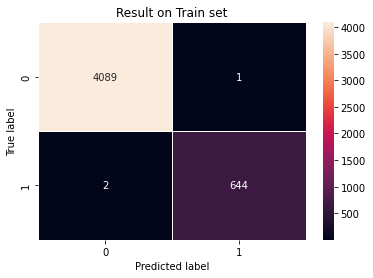

In [17]:
mtx = confusion_matrix(ytrain, ypred_train)
sns.heatmap(mtx, annot=True, fmt='d', linewidths=.8)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Result on Train set')
plt.show()


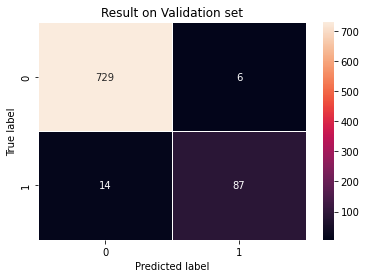

In [18]:
mtx = confusion_matrix(yval, ypred_val)
sns.heatmap(mtx, annot=True, fmt='d', linewidths=.8)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Result on Validation set')
plt.show()

#### Take a look at the **history** recorded by this model, convergence sounds good.

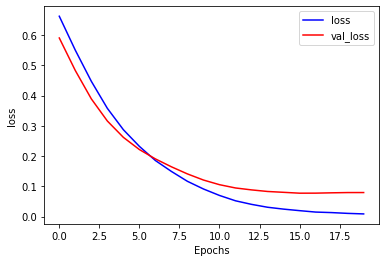

In [19]:
# Visualization of the training process on the loss function 
plt.plot(history.history["loss"], color="b", label='loss')
plt.plot(history.history["val_loss"], color="r", label='val_loss')
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.legend(loc="upper right")
plt.show()


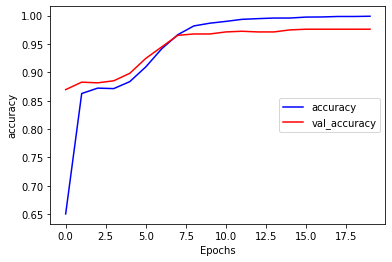

In [20]:
# Visualization of accuracy training 
plt.plot(history.history["accuracy"], color="b", label='accuracy')
plt.plot(history.history["val_accuracy"], color="r", label='val_accuracy')
plt.ylabel("accuracy")
plt.xlabel("Epochs")
plt.legend(loc="right")
plt.show()

### Optionnal : Saving model and history

In [21]:
# model.save("model_embedding_pretrained.h5")

In [22]:
# import json
# json.dump(model.history.history, open("embedding_pretrained_history.json", 'w'))

### Conclusion :
- This model allow us to avoid text cleaning and despite this, it perform very well
- Even if the time computing is quite long, it seems to be a very good solution
- It was quite difficult to test google/universal-sentence-encoder/4 on my own PC due to the time computing very important
- I tried https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2 : very interesting solution, the results were very good with a drawback: overfitting to handle